<a href="https://colab.research.google.com/github/hasbi2000/Water-Quality/blob/main/Klorofil-a%20Mann-Kendall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import ee
import geemap
import xarray as xr
#import ee, geemap and xarray as anything that you want to call, it is oke when you want to call it "hasbi ganteng"

In [3]:
!pip install xee
import xee
# next make sure you installed xee due to xee env is not available in google collabs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00


In [4]:
ee.Authenticate()
ee.Initialize(
    project='hasbihusaini',
    opt_url='https://earthengine-highvolume.googleapis.com')
# next you also make sure that your google cloud has been authencticated on google collabs

In [5]:
map = geemap.Map(basemap = 'SATELLITE')
map
# you must difine your geemap as map in google collabs and next call it

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [6]:
roi = map.draw_last_feature.geometry()
# after creating your area of interest, be sure you have been scripted in the script coulomn

In [7]:
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          96.702033,
                          0.340403
                        ],
                        [
                          96.702033,
                          4.368149
                        ],
                        [
                          101.240365,
                          4.368149
                        ],
                        [
                          101.240365,
                          0.340403
                        ],
                        [
                          96.702033,
                          0.340403
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [9]:
collection = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI").select('chlor_a').filterDate('2010','2022')

collection

ds = xr.open_dataset(collection, engine = 'ee', crs = 'EPSG:4326', scale = 0.05, geometry = roi)

ds

# calling your image data

<xarray.Dataset> Size: 127MB
Dimensions:  (time: 4293, lon: 91, lat: 81)
Coordinates:
  * time     (time) datetime64[ns] 34kB 2010-01-01T00:25:01 ... 2021-12-31T00...
  * lon      (lon) float64 728B 96.73 96.78 96.83 96.88 ... 101.1 101.2 101.2
  * lat      (lat) float64 648B 0.3654 0.4154 0.4654 ... 4.265 4.315 4.365
Data variables:
    chlor_a  (time, lon, lat) float32 127MB ...
Attributes: (12/19)
    date_range:             [1025740800000, 1640908800000]
    description:            <p>This level 3 product includes ocean color and ...
    keywords:               ['biology', 'chlorophyll', 'climate', 'modis', 'n...
    period:                 1
    period_mapping:         [1025740800000, 1640908800000]
    product_tags:           ['temperature', 'weather', 'climate', 'ocean', 'b...
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  Rrs_645,Rrs_555,Rrs_443
    visualization_0_max:    0.011
    visualization_0_min:    0.0
    visualization_0_name:   Remote Sensing Reflectance
    crs:                    EPSG:4326

In [10]:
!pip install pymannkendall
import pymannkendall as mk

In [11]:
import numpy as np
def mk_test(img):
    img = np.array(img)
    img = img[~np.isnan(img)]

    if len(img) < 3:
        return 0, np.nan, np.nan

    test = mk.original_test(img)
    trend = test.trend
    trend_class = {'increasing': 1, 'decreasing': -1, 'no trend': 0}
    trend_reclass = trend_class.get(trend, 0)
    score = test.s
    pval = test.p
    return trend_reclass, score, pval


In [12]:
change_trend, change_score, change_pval = xr.apply_ufunc(
    mk_test,
    ds.chlor_a,
    input_core_dims = [['time']],
    output_core_dims = [[],[],[]],
    dask = 'allowed',
    vectorize = True,
    output_dtypes = ['float64','float64', 'float64']
)


In [ ]:
change_trend

<xarray.DataArray 'trend' (lon: 18, lat: 17)> Size: 2kB
array([[1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        0.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1.],
       [1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.]])
Coordinates:
  * lon      (lon) float64 144B 96.91 96.98 97.05 97.12 ... 97.96 98.03 98.1
  * lat      (lat) float64 136B 0.4525 0.5225 0.5925 ... 1.432 1.502 1.572

In [13]:
change_trend = change_trend.rename('trend')
change_score1 = change_score.rename('score')* 0.0001
change_pval = change_pval.rename('p_value')

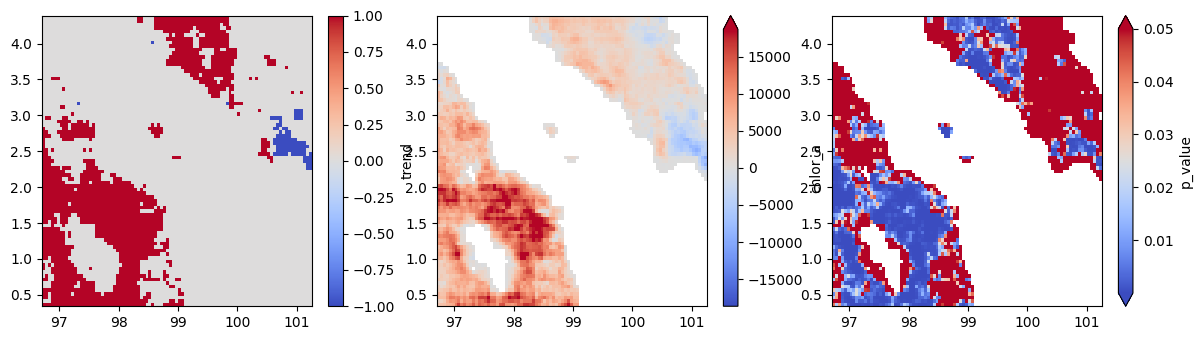

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize = (12,3.5))
plt.tight_layout()

common_cmap = 'coolwarm'

change_trend.plot(x = 'lon', y = 'lat', ax = ax[0], cmap=common_cmap)
change_score.plot(x = 'lon', y = 'lat', ax = ax[1],cmap=common_cmap, robust = True)
change_pval.plot(x = 'lon', y = 'lat', ax = ax[2],cmap=common_cmap, robust = True, vmax = 0.05)

for axis in ax:
  axis.set_ylabel('')
  axis.set_xlabel('')


plt.savefig('mk_change.png', dpi = 360, bbox_inches ='tight')

In [15]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 60.6 MB/s eta 0:00:00


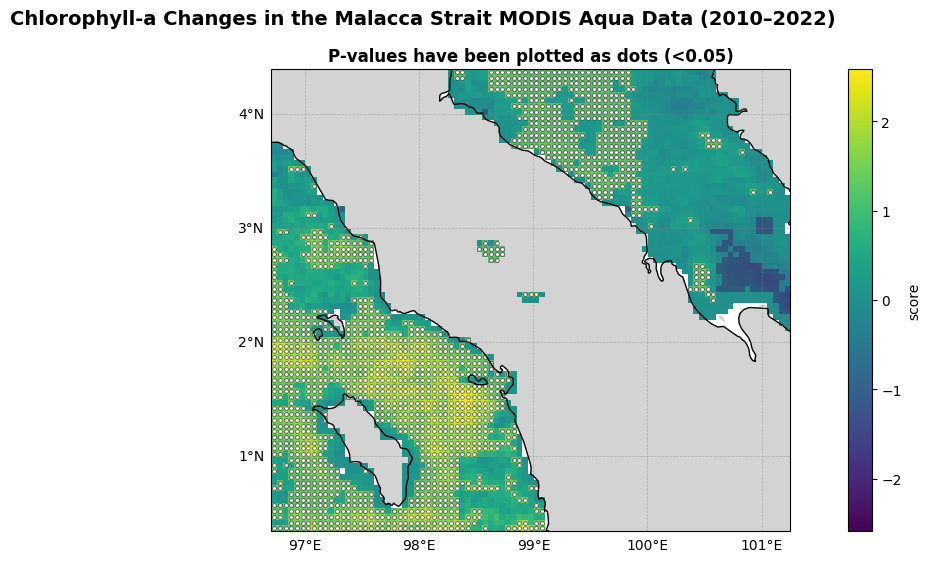

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature

change_trend = change_trend.transpose('lat', 'lon')
z = change_trend.values
lat_original = change_trend.lat.values
lon_original = change_trend.lon.values

lon_new = np.linspace(lon_original.min(), lon_original.max(), 100)
lat_new = np.linspace(lat_original.min(), lat_original.max(), 100)
lon_grid_new, lat_grid_new = np.meshgrid(lon_new, lat_new)

lon_flat_original, lat_flat_original = np.meshgrid(lon_original, lat_original)
points = np.column_stack([lon_flat_original.ravel(), lat_flat_original.ravel()])
values = z.ravel()
z_interp = griddata(points, values, (lon_grid_new, lat_grid_new), method='linear')

assert z_interp.shape == (100, 100), f"Unexpected shape: {z_interp.shape}"

change_trend_interp = xr.DataArray(
    data=z_interp,dims=["lat", "lon"],coords={"lat": lat_new, "lon": lon_new})

lon_grid_original, lat_grid_original = np.meshgrid(lon_original, lat_original)
mask = (z >= 0.05) & ~np.isnan(z)
x_points = lon_grid_original[mask]
y_points = lat_grid_original[mask]
common_cmap = 'viridis'
fig, ax = plt.subplots(figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
masked_data = change_trend.where((change_trend == -1) | (change_trend == 1))
change_score1.plot(x='lon', y='lat', ax=ax,cmap=common_cmap,robust=False,add_colorbar=True,transform=ccrs.PlateCarree())
masked_data.plot(x='lon', y='lat', ax=ax, cmap=common_cmap, robust=True, add_colorbar=False,transform=ccrs.PlateCarree(), alpha=0.3)

ax.scatter(x_points, y_points,facecolor='white', edgecolor='black',s=7, linewidth=0.3, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
fig.suptitle("Chlorophyll-a Changes in the Malacca Strait MODIS Aqua Data (2010–2022)", fontsize=14, fontweight='bold', ha='center')
ax.set_title("P-values have been plotted as dots (<0.05)", fontsize=12, fontweight='bold')

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}
plt.savefig("chlorophyll_changes.png", dpi=600, bbox_inches='tight')